In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12895376598406086410, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12521319578565717133
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [3]:
!cat /proc/meminfo

MemTotal:       13333548 kB
MemFree:         9644840 kB
MemAvailable:   12049756 kB
Buffers:           85852 kB
Cached:          2325844 kB
SwapCached:            0 kB
Active:          1272120 kB
Inactive:        1998148 kB
Active(anon):     680088 kB
Inactive(anon):    10604 kB
Active(file):     592032 kB
Inactive(file):  1987544 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               612 kB
Writeback:             0 kB
AnonPages:        858620 kB
Mapped:           551200 kB
Shmem:             11260 kB
Slab:             183308 kB
SReclaimable:     132424 kB
SUnreclaim:        50884 kB
KernelStack:        4576 kB
PageTables:         8516 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666772 kB
Committed_AS:    3682516 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1048 kB
AnonHugePages:   

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [4]:
# importing dataset
skin_df = pd.read_csv('/content/drive/MyDrive/archive/HAM10000_metadata.csv')

# declaring size of image taken by CNN
SIZE=64

In [5]:
# Giving our labels a numeric value
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [6]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx  ...     sex     localization label
1617  HAM_0007180  ISIC_0033272  mel  ...    male             face     4
8128  HAM_0007195  ISIC_0031923   nv  ...  female  lower extremity     5
2168  HAM_0001835  ISIC_0026652  mel  ...    male             back     4
1090  HAM_0000465  ISIC_0030583  bkl  ...  female            trunk     2
7754  HAM_0001720  ISIC_0034010   nv  ...    male          abdomen     5
8071  HAM_0006333  ISIC_0024424   nv  ...    male            trunk     5
7423  HAM_0004548  ISIC_0032832   nv  ...  female  upper extremity     5
8984  HAM_0006526  ISIC_0026671   nv  ...    male  lower extremity     5
2310  HAM_0003102  ISIC_0032389  mel  ...    male             face     4
7256  HAM_0004260  ISIC_0025525   nv  ...    male             back     5

[10 rows x 8 columns]


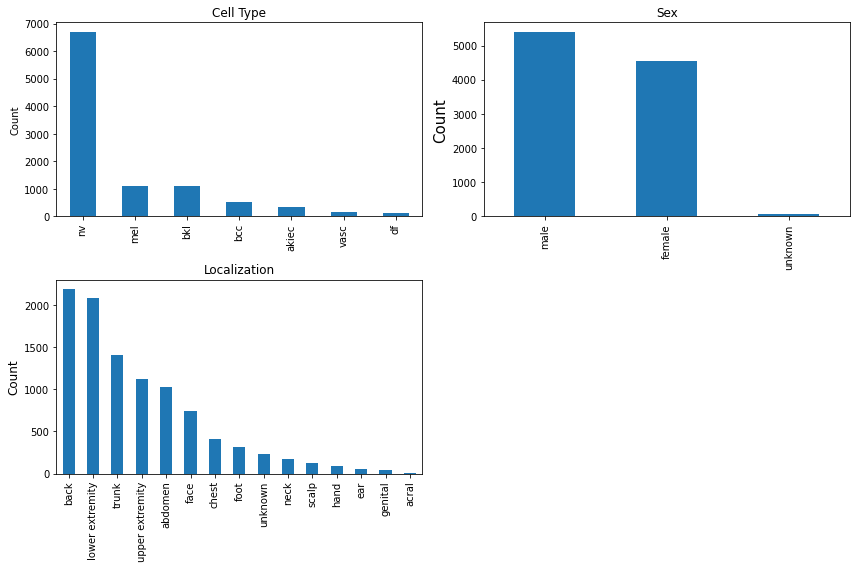

In [7]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

# type vs count
ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

# sex vs count
ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

# area vs count
ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

plt.tight_layout()
plt.show()

In [8]:
# getting no of images of each type
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [9]:
# resampling the data with taking 1000 samples of each type
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=1000 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [10]:
print(skin_df_balanced['label'].value_counts())

3    1000
6    1000
2    1000
5    1000
1    1000
4    1000
0    1000
Name: label, dtype: int64


In [11]:
# joining two folders of images
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/drive/MyDrive/archive/', '*', '*.jpg'))}


skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

# resizing all the images to 64*64
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

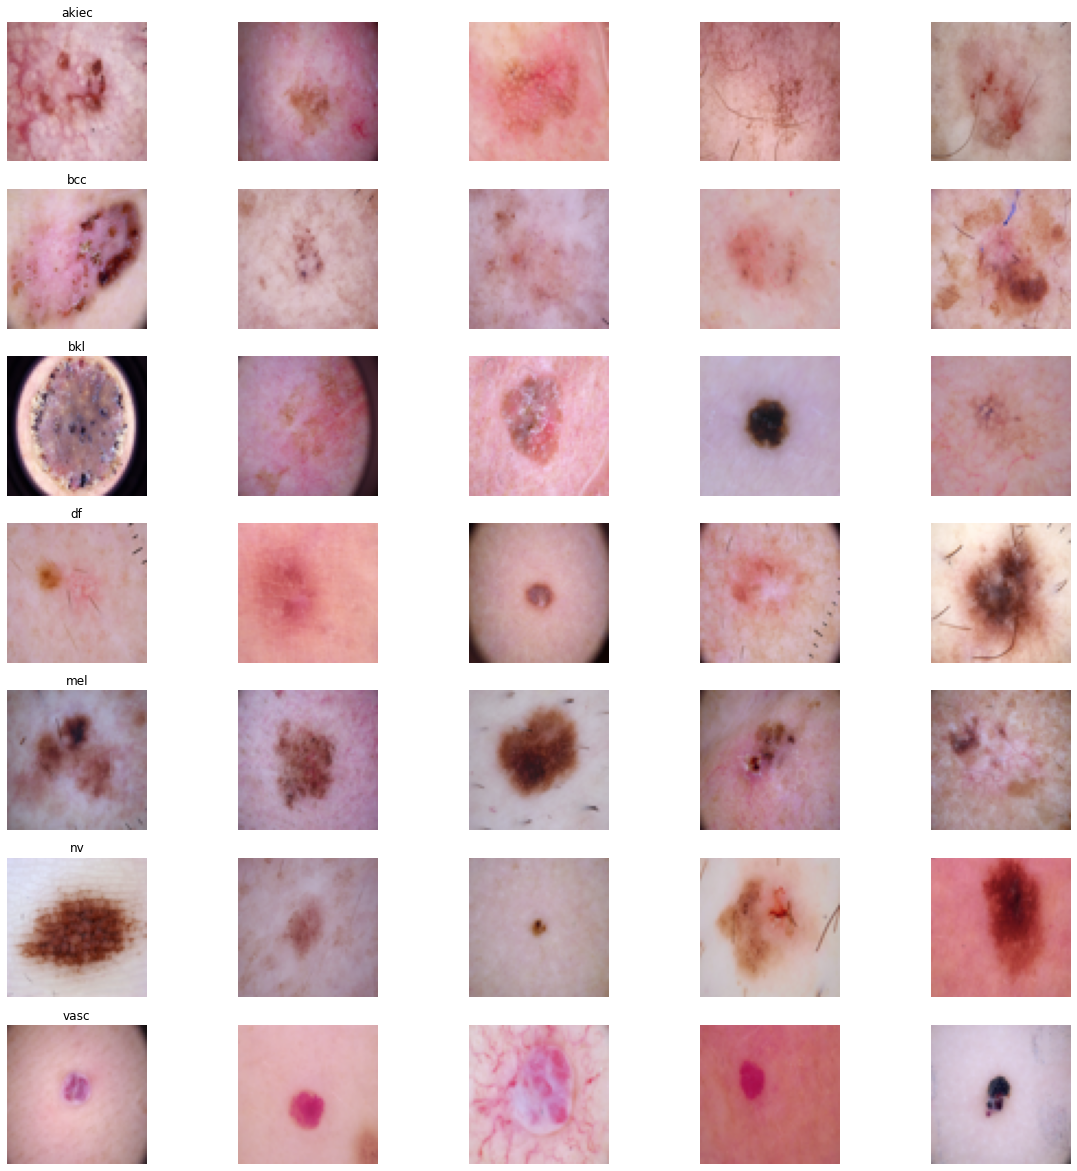

In [12]:
# plotting 5 images of each type
n_samples = 5  
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [13]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  
Y=skin_df_balanced['label']  
# categorical conversion
Y_cat = to_categorical(Y, num_classes=7) 
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [14]:
# Architecture of the model
num_classes = 7

model = Sequential()
model.add(Conv2D(512, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 512)       14336     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       1179904   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       2

In [15]:
# training the model on the training dataset
batch_size = 16 
epochs = 75

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/75
329/329 - 41s - loss: 1.8880 - acc: 0.1882 - val_loss: 1.7400 - val_acc: 0.2600
Epoch 2/75
329/329 - 7s - loss: 1.7523 - acc: 0.2613 - val_loss: 1.7111 - val_acc: 0.2611
Epoch 3/75
329/329 - 7s - loss: 1.6948 - acc: 0.2800 - val_loss: 1.5398 - val_acc: 0.3320
Epoch 4/75
329/329 - 7s - loss: 1.5030 - acc: 0.3747 - val_loss: 1.4442 - val_acc: 0.3669
Epoch 5/75
329/329 - 7s - loss: 1.4364 - acc: 0.4061 - val_loss: 1.4161 - val_acc: 0.4229
Epoch 6/75
329/329 - 7s - loss: 1.3721 - acc: 0.4350 - val_loss: 1.4045 - val_acc: 0.4131
Epoch 7/75
329/329 - 7s - loss: 1.3271 - acc: 0.4606 - val_loss: 1.2780 - val_acc: 0.4583
Epoch 8/75
329/329 - 7s - loss: 1.2745 - acc: 0.4937 - val_loss: 1.2635 - val_acc: 0.4943
Epoch 9/75
329/329 - 7s - loss: 1.2407 - acc: 0.5093 - val_loss: 1.2190 - val_acc: 0.5560
Epoch 10/75
329/329 - 7s - loss: 1.1754 - acc: 0.5402 - val_loss: 1.1786 - val_acc: 0.5509
Epoch 11/75
329/329 - 7s - loss: 1.1518 - acc: 0.5482 - val_loss: 1.1655 - val_acc: 0.5566
Epoch 1

In [16]:
# Testing the accuracy on the testing data
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

55/55 [==============================] - 2s 21ms/step - loss: 0.5703 - acc: 0.8046
Test accuracy: 0.8045714497566223


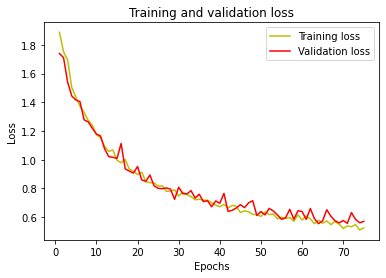

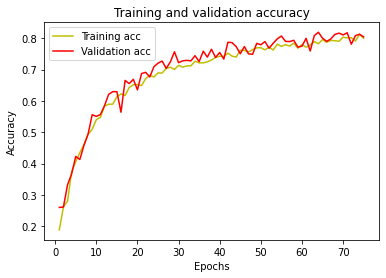

<Figure size 432x288 with 0 Axes>

In [17]:
# plotting the loss graph
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# printing the accuracy graph
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

In [19]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

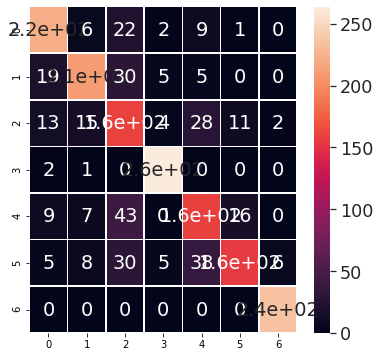

In [20]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

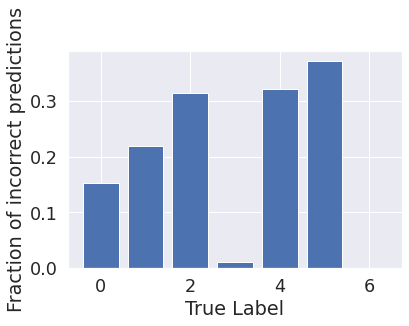

In [21]:
#PLotting no of incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [18]:
model.save('skin_model.h5')

In [22]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.preprocessing import image

In [23]:
lesion_classes_dict = {
    0 : 'Actinic keratoses',
    1 : 'Basal cell carcinoma',
    2 : 'Benign keratosis-like lesions ',
    3 : 'Dermatofibroma',
    4 : 'Melanoma',
    5 : 'Melanocytic nevi',
    6 : 'Vascular lesions'
}

In [25]:
# printing the prediction understandable by the user
def model_predict(img_path, Model):
    img = image.load_img(img_path, target_size=(64,64,3))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    preds = Model.predict(x)
    pred_class = preds.argmax(axis=-1)
    pr = lesion_classes_dict[pred_class[0]]
    result =str(pr)
    return result
Model = load_model('skin_model.h5')


img_path = "nv1.jfif"
model_predict(img_path,Model)

'Basal cell carcinoma'